In [4]:
!pip install pandas openai tqdm tenacity scikit-learn tiktoken python-dotenv seaborn --upgrade --quiet


In [5]:
import json
import os
import time

import pandas as pd
from openai import OpenAI
import tiktoken
import seaborn as sns
from tenacity import retry, wait_exponential
from tqdm import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

In [10]:
from google.colab import userdata
OPEN_AI_KEY=userdata.get('opeaikey4o')
QDRANT_key=userdata.get('QDRANTkey')

## Set the API key and model name
MODEL="gpt-3.5-turbo"
client = OpenAI(api_key=OPEN_AI_KEY)

Table of Contents

Setting up the Environment

Section A: Zero-Shot Learning

Data Preparation: SQuADv2 Dataset

Answering using Base gpt-3.5-turbo-0613 model

Fine-tuning and Answering using Fine-tuned model

Evaluation: How well does the model perform?

Section B: Few-Shot Learning

Using Qdrant to Improve RAG Prompt

Fine-Tuning OpenAI Model with Qdrant

Evaluation

Conclusion

Aggregate Results

Observations

Install and Import Dependencies

###Section A

###Data Preparation: SQuADv2 Data Subsets
For the purpose of demonstration, we'll make small slices from the train and validation splits of the SQuADv2 dataset. This dataset has questions and contexts where the answer is not present in the context, to help us evaluate how LLM handles this case.

We'll read the data from the JSON files and create a dataframe with the following columns: question, context, answer, is_impossible.

#####Download the Data

In [ ]:
# !mkdir -p local_cache
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O local_cache/train.json
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O local_cache/dev.json

In [19]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O train.json

--2024-06-24 18:05:09--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train.json’

train.json          100%[===================>]  40.17M   197MB/s    in 0.2s    

2024-06-24 18:05:10 (197 MB/s) - ‘train.json’ saved [42123633/42123633]



In [20]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O dev.json

--2024-06-24 18:05:12--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev.json’

dev.json            100%[===================>]   4.17M  --.-KB/s    in 0.08s   

2024-06-24 18:05:12 (49.6 MB/s) - ‘dev.json’ saved [4370528/4370528]



###Read JSON to DataFrame

In [42]:
def json_to_dataframe_with_titles(json_data):
    qas = []
    context = []
    is_impossible = []
    answers = []
    titles = []

    for article in json_data['data']:
        title = article['title']
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                qas.append(qa['question'].strip())
                context.append(paragraph['context'])
                is_impossible.append(qa['is_impossible'])

                ans_list = []
                for ans in qa['answers']:
                    ans_list.append(ans['text'])
                answers.append(ans_list)
                titles.append(title)

    df = pd.DataFrame({'title': titles, 'question': qas, 'context': context, 'is_impossible': is_impossible, 'answers': answers})
    return df

def get_diverse_sample(df, sample_size=100, random_state=42):
    """
    Get a diverse sample of the dataframe by sampling from each title
    """
    sample_df = df.groupby(['title', 'is_impossible']).apply(lambda x: x.sample(min(len(x), max(1, sample_size // 50)), random_state=random_state)).reset_index(drop=True)

    if len(sample_df) < sample_size:
        remaining_sample_size = sample_size - len(sample_df)
        remaining_df = df.drop(sample_df.index).sample(remaining_sample_size, random_state=random_state)
        sample_df = pd.concat([sample_df, remaining_df]).sample(frac=1, random_state=random_state).reset_index(drop=True)

    return sample_df.sample(min(sample_size, len(sample_df)), random_state=random_state).reset_index(drop=True)

train_df = json_to_dataframe_with_titles(json.load(open('train.json')))
val_df = json_to_dataframe_with_titles(json.load(open('dev.json')))

df = get_diverse_sample(val_df, sample_size=100, random_state=42)

#####    Get a diverse sample of the dataframe by sampling from each title


In [43]:
train_df.head()

,title,question,context,is_impossible,answers
0,Beyoncé,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[in the late 1990s]
1,Beyoncé,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[singing and dancing]
2,Beyoncé,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[2003]
3,Beyoncé,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,"[Houston, Texas]"
4,Beyoncé,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[late 1990s]


In [23]:
train_df['context'][0]

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [44]:
val_df.head()

,title,question,context,is_impossible,answers
0,Normans,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,False,"[France, France, France, France]"
1,Normans,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,False,"[10th and 11th centuries, in the 10th and 11th..."
2,Normans,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,False,"[Denmark, Iceland and Norway, Denmark, Iceland..."
3,Normans,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,False,"[Rollo, Rollo, Rollo, Rollo]"
4,Normans,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,False,"[10th century, the first half of the 10th cent..."


In [45]:

df.head()

,title,question,context,is_impossible,answers
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[]
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[]
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[]
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[]


###Answering using Base gpt-3.5-turbo-0613 model

Let's start by using the base gpt-3.5-turbo-0613 model to answer the questions. This prompt is a simple concatenation of the question and context, with a separator token in between: \n\n. We've a simple instruction part of the prompt:

Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.

Other prompts are possible, but this is a good starting point. We'll use this prompt to answer the questions in the validation set.

### Function to get prompt messages

In [46]:
# Function to get prompt messages
def get_prompt(row):
    return [
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
    Question: {row.question}\n\n
    Context: {row.context}\n\n
    Answer:\n""",
        },
    ]

###Answering using Zero Shot Prompt

Next, you'll need some re-usable functions which make an OpenAI API Call and return the answer. You'll use the ChatCompletion.create endpoint of the API, which takes a prompt and returns the completed text.



##### Function with tenacity for retries


In [47]:
# Function with tenacity for retries
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def api_call(messages, model):
    return client.chat.completions.create(
        model=model,
        messages=messages,
        stop=["\n\n"],
        max_tokens=100,
        temperature=0.0,
    )


# Main function to answer question
def answer_question(row, prompt_func=get_prompt, model="gpt-3.5-turbo"):
    messages = prompt_func(row)
    response = api_call(messages, model)
    return response.choices[0].message.content

##### Main function to answer question


In [48]:
# Use progress_apply with tqdm for progress bar
df["generated_answer"] = df.progress_apply(answer_question, axis=1)


  0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
df.head()

,title,question,context,is_impossible,answers,generated_answer
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,Scottish MPs sitting in the UK House of Common...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know.
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],Gender roles and customs.
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],California
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],1755


In [50]:
df.to_json("100_val.json", orient="records", lines=True)
df = pd.read_json("100_val.json", orient="records", lines=True)

⏰ Time to run: ~3 min, 🛜 Needs Internet Connection

In [51]:
df

,title,question,context,is_impossible,answers,generated_answer
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,Scottish MPs sitting in the UK House of Common...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know.
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],Gender roles and customs.
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],California
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],1755
...,...,...,...,...,...,...
95,Geology,"In the layered Earth model, what is the inner ...",Seismologists can use the arrival times of sei...,True,[],Seismic discontinuities at 410 and 660 kilomet...
96,Prime_number,What type of value would the Basel function ha...,The zeta function is closely related to prime ...,True,[],The Basel function would have a finite value i...
97,"Fresno,_California",What does the San Joaquin Valley Railroad cros...,Passenger rail service is provided by Amtrak S...,True,[],The San Joaquin Valley Railroad crosses with t...
98,Victoria_(Australia),What party rules in Melbourne's inner regions?,"The centre-left Australian Labor Party (ALP), ...",False,"[The Greens, Australian Greens, Greens]",The Australian Greens are strongest in inner M...


In [52]:
df['context'][1]

'The principles of imperialism are often generalizable to the policies and practices of the British Empire "during the last generation, and proceeds rather by diagnosis than by historical description". British imperialism often used the concept of Terra nullius (Latin expression which stems from Roman law meaning \'empty land\'). The country of Australia serves as a case study in relation to British settlement and colonial rule of the continent in the eighteenth century, as it was premised on terra nullius, and its settlers considered it unused by its sparse Aboriginal inhabitants.'

## Fine-tuning and Answering using Fine-tuned model

####Prepare the Fine-Tuning Data

In [53]:
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        answer = row["answers"][0] if row["answers"] else "I don't know"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
            Question: {row.question}\n\n
            Context: {row.context}\n\n
            Answer:\n""",
            },
            {"role": "assistant", "content": answer},
        ]
        return json.dumps({"messages": messages})

    jsonl_output = df.apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

train_sample = get_diverse_sample(train_df, sample_size=100, random_state=42)

with open("100_train.jsonl", "w") as f:
    f.write(dataframe_to_jsonl(train_sample))

##Fine-Tune OpenAI Model

In [54]:
class OpenAIFineTuner:
    """
    Class to fine tune OpenAI models
    """
    def __init__(self, training_file_path, model_name, suffix):
        self.training_file_path = training_file_path
        self.model_name = model_name
        self.suffix = suffix
        self.file_object = None
        self.fine_tuning_job = None
        self.model_id = None

    def create_openai_file(self):
        self.file_object = client.files.create(
            file=open(self.training_file_path, "rb"),
            purpose="fine-tune",
        )

    def wait_for_file_processing(self, sleep_time=20):
        while self.file_object.status != 'processed':
            time.sleep(sleep_time)
            print("File Status: ", self.file_object.status)

    def create_fine_tuning_job(self):
        self.fine_tuning_job = client.fine_tuning.jobs.create(
            training_file=self.file_object.id,
            model=self.model_name,
            suffix=self.suffix,
        )

    def wait_for_fine_tuning(self, sleep_time=45):
        while self.fine_tuning_job.status != 'succeeded':
            time.sleep(sleep_time)
            print("Job Status: ", self.fine_tuning_job.status)

    def retrieve_fine_tuned_model(self):
        self.model_id = client.fine_tuning.jobs.retrieve(self.fine_tuning_job.id).fine_tuned_model
        return self.model_id

    def fine_tune_model(self):
        self.create_openai_file()
        self.wait_for_file_processing()
        self.create_fine_tuning_job()
        self.wait_for_fine_tuning()
        return self.retrieve_fine_tuned_model()

fine_tuner = OpenAIFineTuner(
        training_file_path="100_train.jsonl",
        model_name="gpt-3.5-turbo",
        suffix="100trn20230907"
    )

In [ ]:
model_id = fine_tuner.fine_tune_model()
model_id

In [ ]:
model_name_id="ft:gpt-3.5-turbo-0125:personal:100trn20230907:9dHWdCQI"
model_name_id

'ft:gpt-3.5-turbo-0125:personal:100trn20230907:9dHWdCQI'

##Try out the Fine-Tuned Model

In [ ]:
completion=client.chat.completions.create(
    model=model_name_id,
    messages=[
        {"role":"system","content":"You are a helpful assistant."},
        {"role":"user","content":"Hello"},
        {"role":"assistant","content":"Hello, how can I help you today?"},
        {
            "role":"user",
            "content":"Can you answer the following question based on the given context? if not ,say 'I don't know"
        },
    ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content="Of course! Please go ahead and provide the question and context, and I'll do my best to help you out.", role='assistant', function_call=None, tool_calls=None)


##Answer Using the Fine-Tuned Model
⏰ Time to run: ~5 min, 🛜 Needs Internet Connection

In [ ]:
df["ft_generated_answer"] = df.progress_apply(answer_question, model=model_name_id, axis=1)

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


In [ ]:
df.to_json("100_val_ft.json", orient="records", lines=True)
df = pd.read_json("100_val_ft.json", orient="records", lines=True)

In [ ]:
df

,title,question,context,is_impossible,answers,generated_answer,ft_generated_answer
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,Scottish MPs sitting in the UK House of Common...,Scottish MPs sitting in the UK House of Common...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know.,I don't know
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],Gender roles and customs.,I don't know
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],California,I don't know
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],1755,I don't know
...,...,...,...,...,...,...,...
95,Geology,"In the layered Earth model, what is the inner ...",Seismologists can use the arrival times of sei...,True,[],Seismic discontinuities at 410 and 660 kilomet...,seismic discontinuities
96,Prime_number,What type of value would the Basel function ha...,The zeta function is closely related to prime ...,True,[],The Basel function would have a finite value i...,I don't know
97,"Fresno,_California",What does the San Joaquin Valley Railroad cros...,Passenger rail service is provided by Amtrak S...,True,[],The San Joaquin Valley Railroad crosses former...,I don't know
98,Victoria_(Australia),What party rules in Melbourne's inner regions?,"The centre-left Australian Labor Party (ALP), ...",False,"[The Greens, Australian Greens, Greens]",The Australian Greens are strongest in inner M...,Greens


#5. Evaluation: How well does the model perform?

To evaluate the model's performance, compare the predicted answer to the actual answers -- if any of the actual answers are present in the predicted answer, then it's a match. We've also created error categories to help you understand where the model is struggling.

When we know that a correct answer exists in the context, we can measure the model's performance, there are 3 possible outcomes:

✅ Answered Correctly: The model responded the correct answer. It may have also included other answers that were not in the context.

❎ Skipped: The model responded with "I don't know" (IDK) while the answer was present in the context. It's better than giving the wrong answer. It's better for the model say "I don't know" than giving the wrong answer. In our design, we know that a true answer exists and hence we're able to measure it -- this is not always the case. This is a model error. We exclude this from the overall error rate.

❌ Wrong: The model responded with an incorrect answer. This is a model ERROR.
When we know that a correct answer does not exist in the context, we can measure the model's performance, there are 2 possible outcomes:

❌ Hallucination: The model responded with an answer, when "I don't know" was expected. This is a model ERROR.

✅ I don't know: The model responded with "I don't know" (IDK) and the answer was not present in the context. This is a model WIN.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
df = pd.read_json("100_val_ft.json", orient="records", lines=True)

In [56]:
df.head()

,title,question,context,is_impossible,answers,generated_answer,ft_generated_answer
0,Scottish_Parliament,What consequence of establishing the Scottish ...,A procedural consequence of the establishment ...,False,[able to vote on domestic legislation that app...,Scottish MPs sitting in the UK House of Common...,Scottish MPs sitting in the UK House of Common...
1,Imperialism,Imperialism is less often associated with whic...,The principles of imperialism are often genera...,True,[],I don't know.,I don't know
2,Economic_inequality,What issues can't prevent women from working o...,"When a person’s capabilities are lowered, they...",True,[],Gender roles and customs.,I don't know
3,Southern_California,"What county are Los Angeles, Orange, San Diego...","Its counties of Los Angeles, Orange, San Diego...",True,[],California,I don't know
4,French_and_Indian_War,When was the deportation of Canadians?,Britain gained control of French Canada and Ac...,True,[],1755,I don't know


#5. Evaluation: How well does the model perform?
To evaluate the model's performance, compare the predicted answer to the actual answers -- if any of the actual answers are present in the predicted answer, then it's a match. We've also created error categories to help you understand where the model is struggling.

When we know that a correct answer exists in the context, we can measure the model's performance, there are 3 possible outcomes:

✅ Answered Correctly: The model responded the correct answer. It may have also included other answers that were not in the context.

❎ Skipped: The model responded with "I don't know" (IDK) while the answer was present in the context. It's better than giving the wrong answer. It's better for the model say "I don't know" than giving the wrong answer. In our design, we know that a true answer exists and hence we're able to measure it -- this is not always the case. This is a model error. We exclude this from the overall error rate.

❌ Wrong: The model responded with an incorrect answer. This is a model ERROR.
When we know that a correct answer does not exist in the context, we can measure the model's performance, there are 2 possible outcomes:

❌ Hallucination: The model responded with an answer, when "I don't know" was expected. This is a model ERROR.

✅ I don't know: The model responded with "I don't know" (IDK) and the answer was not present in the context. This is a model WIN.

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class Evaluator:
    def __init__(self, df):
        self.df = df
        self.y_pred = pd.Series()  # Initialize as empty Series
        self.labels_answer_expected = ["✅ Answered Correctly", "❎ Skipped", "❌ Wrong Answer"]
        self.labels_idk_expected = ["❌ Hallucination", "✅ I don't know"]

    def _evaluate_answer_expected(self, row, answers_column):
        generated_answer = row[answers_column].lower()
        actual_answers = [ans.lower() for ans in row["answers"]]
        return (
            "✅ Answered Correctly" if any(ans in generated_answer for ans in actual_answers)
            else "❎ Skipped" if generated_answer == "i don't know"
            else "❌ Wrong Answer"
        )

    def _evaluate_idk_expected(self, row, answers_column):
        generated_answer = row[answers_column].lower()
        return (
            "❌ Hallucination" if generated_answer != "i don't know"
            else "✅ I don't know"
        )

    def _evaluate_single_row(self, row, answers_column):
        is_impossible = row["is_impossible"]
        return (
            self._evaluate_answer_expected(row, answers_column) if not is_impossible
            else self._evaluate_idk_expected(row, answers_column)
        )

    def evaluate_model(self, answers_column="generated_answer"):
        self.y_pred = pd.Series(self.df.apply(self._evaluate_single_row, answers_column=answers_column, axis=1))
        freq_series = self.y_pred.value_counts()

        # Counting rows for each scenario
        total_answer_expected = len(self.df[self.df['is_impossible'] == False])
        total_idk_expected = len(self.df[self.df['is_impossible'] == True])

        freq_answer_expected = (freq_series / total_answer_expected * 100).round(2).reindex(self.labels_answer_expected, fill_value=0)
        freq_idk_expected = (freq_series / total_idk_expected * 100).round(2).reindex(self.labels_idk_expected, fill_value=0)
        return freq_answer_expected.to_dict(), freq_idk_expected.to_dict()

    def print_eval(self):
        answer_columns=["generated_answer", "ft_generated_answer"]
        baseline_correctness, baseline_idk = self.evaluate_model()
        ft_correctness, ft_idk = self.evaluate_model(self.df, answer_columns[1])
        print("When the model should answer correctly:")
        eval_df = pd.merge(
            baseline_correctness.rename("Baseline"),
            ft_correctness.rename("Fine-Tuned"),
            left_index=True,
            right_index=True,
        )
        print(eval_df)
        print("\n\n\nWhen the model should say 'I don't know':")
        eval_df = pd.merge(
            baseline_idk.rename("Baseline"),
            ft_idk.rename("Fine-Tuned"),
            left_index=True,
            right_index=True,
        )
        print(eval_df)

    def plot_model_comparison(self, answer_columns=["generated_answer", "ft_generated_answer"], scenario="answer_expected", nice_names=["Baseline", "Fine-Tuned"]):

        results = []
        for col in answer_columns:
            answer_expected, idk_expected = self.evaluate_model(col)
            if scenario == "answer_expected":
                results.append(answer_expected)
            elif scenario == "idk_expected":
                results.append(idk_expected)
            else:
                raise ValueError("Invalid scenario")


        results_df = pd.DataFrame(results, index=nice_names)
        if scenario == "answer_expected":
            results_df = results_df.reindex(self.labels_answer_expected, axis=1)
        elif scenario == "idk_expected":
            results_df = results_df.reindex(self.labels_idk_expected, axis=1)

        melted_df = results_df.reset_index().melt(id_vars='index', var_name='Status', value_name='Frequency')
        sns.set_theme(style="whitegrid", palette="icefire")
        g = sns.catplot(data=melted_df, x='Frequency', y='index', hue='Status', kind='bar', height=5, aspect=2)

        # Annotating each bar
        for p in g.ax.patches:
            g.ax.annotate(f"{p.get_width():.0f}%", (p.get_width()+5, p.get_y() + p.get_height() / 2),
                        textcoords="offset points",
                        xytext=(0, 0),
                        ha='center', va='center')
        plt.ylabel("Model")
        plt.xlabel("Percentage")
        plt.xlim(0, 100)
        plt.tight_layout()
        plt.title(scenario.replace("_", " ").title())
        plt.show()


# Compare the results by merging into one dataframe
evaluator = Evaluator(df)
# evaluator.evaluate_model(answers_column="ft_generated_answer")
# evaluator.plot_model_comparison(["generated_answer", "ft_generated_answer"], scenario="answer_expected", nice_names=["Baseline", "Fine-Tuned"])

In [59]:
# Optionally, save the results to a JSON file
df.to_json("100_val_ft.json", orient="records", lines=True)
df = pd.read_json("100_val_ft.json", orient="records", lines=True)

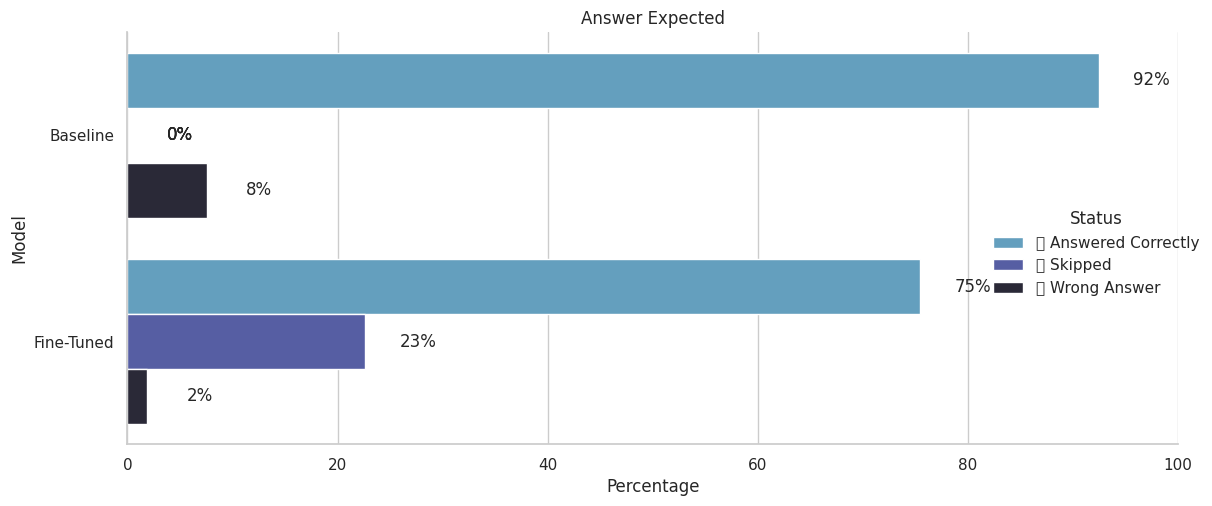

In [60]:
evaluator.plot_model_comparison(["generated_answer", "ft_generated_answer"], scenario="answer_expected", nice_names=["Baseline", "Fine-Tuned"])

Notice that the fine-tuned model skips questions more often -- and makes fewer mistakes. This is because the fine-tuned model is more conservative and skips questions when it's not sure.



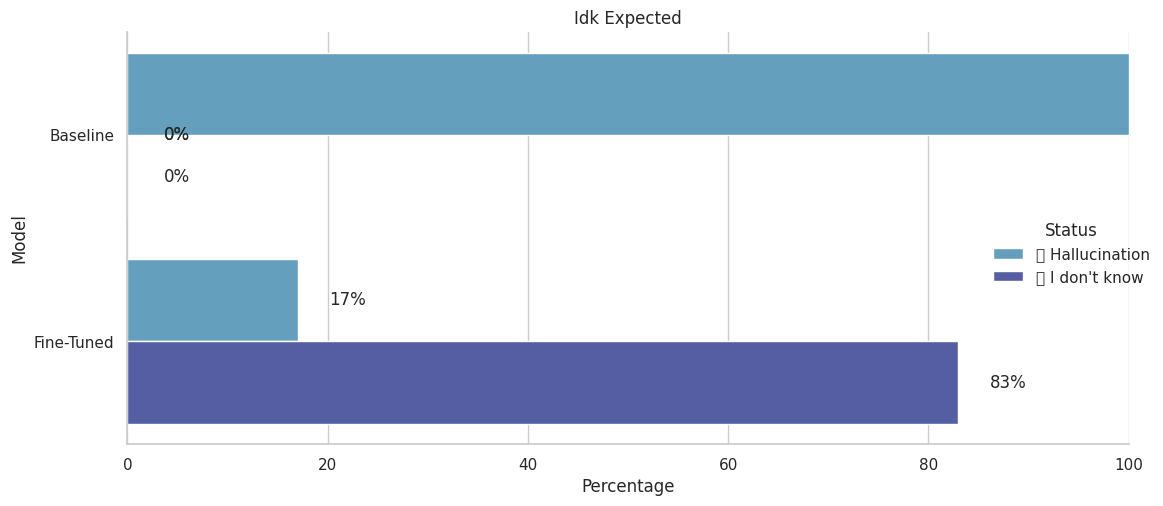

In [61]:
evaluator.plot_model_comparison(["generated_answer", "ft_generated_answer"], scenario="idk_expected", nice_names=["Baseline", "Fine-Tuned"])

#Section B: Few Shot Learning

We'll select a few examples from the dataset, including cases where the answer is not present in the context. We'll then use these examples to create a prompt that we can use to fine-tune the model. We'll then measure the performance of the fine-tuned model.

What is next?

Fine-Tuning OpenAI Model with Qdrant 6.1 Embed the Fine-Tuning Data 6.2 Embedding the Questions
Using Qdrant to Improve RAG Prompt
Evaluation
## 6. Fine-Tuning OpenAI Model with Qdrant
So far, we've been using the OpenAI model to answer questions without using examples of the answer. The previous step made it work better on in-context examples, while this one helps it generalize to unseen data, and attempt to learn when to say "I don't know" and when to give an answer.

This is where few-shot learning comes in!

Few-shot learning is a type of transfer learning that allows us to answer questions where the answer is not present in the context. We can do this by providing a few examples of the answer we're looking for, and the model will learn to answer questions where the answer is not present in the context.

###5.1 Embed the Training Data
Embeddings are a way to represent sentences as an array of floats. We'll use the embeddings to find the most similar questions to the ones we're looking for.

In [8]:
!pip install qdrant_client --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.1/230.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.1 which is incompatible.
google-ai-generativelanguage 0.6.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.1 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21

In [9]:
import os
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct
from qdrant_client.http.models import Distance, VectorParams

Now that we've the Qdrant imports in place,



In [11]:
qdrant_url="https://9bf55def-bb74-40b9-a22a-e63f62b81edd.us-east4-0.gcp.cloud.qdrant.io:6333"

In [12]:
qdrant_client = QdrantClient(url=qdrant_url,api_key=QDRANT_key,timeout=6000,prefer_grpc=True)

In [13]:
collection_name = "squadv2-cookbook"

In [14]:
# # # Create the collection, run this only once
# qdrant_client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config=VectorParams(size=384, distance=Distance.COSINE),
# )

True

In [17]:
!pip install  fastembed --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 715.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have p

In [18]:
from fastembed.embedding import DefaultEmbedding
from typing import List
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

embedding_model = DefaultEmbedding()

2024-06-24 18:03:42.251 | WARNING  | fastembed.embedding:<module>:7 - DefaultEmbedding, FlagEmbedding, JinaEmbedding are deprecated.Use from fastembed import TextEmbedding instead.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/66.5M [00:00<?, ?B/s]

#5.2 Embedding the Questions
Next, you'll embed the entire training set questions. You'll use the question to question similarity to find the most similar questions to the question we're looking for. This is a workflow which is used in RAG to leverage the OpenAI model ability of incontext learning with more examples. This is what we call Few Shot Learning here.

❗️⏰ Important Note: This step can take up to 3 hours to complete. Please be patient. If you see Out of Memory errors or Kernel Crashes, please reduce the batch size to 32, restart the kernel and run the notebook again. This code needs to be run only ONCE.

Function Breakdown for generate_points_from_dataframe
Initialization: batch_size = 512 and total_batches set the stage for how many questions will be processed in one go. This is to prevent memory issues. If your machine can handle more, feel free to increase the batch size. If your kernel crashes, reduce the batch size to 32 and try again.

Progress Bar: tqdm gives you a nice progress bar so you don't fall asleep.
Batch Loop: The for-loop iterates through batches. start_idx and end_idx define the slice of the DataFrame to process.

Generate Embeddings: batch_embeddings = embedding_model.embed(batch, batch_size=batch_size) - This is where the magic happens. Your questions get turned into embeddings.

PointStruct Generation: Using .progress_apply, it turns each row into a PointStruct object. This includes an ID, the embedding vector, and other metadata.

Returns the list of PointStruct objects, which can be used to create a collection in Qdrant.

In [35]:
def generate_points_from_dataframe(df: pd.DataFrame) -> List[PointStruct]:
    batch_size = 32
    questions = df["question"].tolist()
    total_batches = len(questions) // batch_size + 1

    pbar = tqdm(total=len(questions), desc="Generating embeddings")

    # Generate embeddings in batches to improve performance
    embeddings = []
    for i in range(total_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(questions))
        batch = questions[start_idx:end_idx]

        batch_embeddings = embedding_model.embed(batch, batch_size=batch_size)
        embeddings.extend(batch_embeddings)
        pbar.update(len(batch))

    pbar.close()

    # Convert embeddings to list of lists
    embeddings_list = [embedding.tolist() for embedding in embeddings]

    # Create a temporary DataFrame to hold the embeddings and existing DataFrame columns
    temp_df = df.copy()
    temp_df["embeddings"] = embeddings_list
    temp_df["id"] = temp_df.index

    # Generate PointStruct objects using DataFrame apply method
    points = temp_df.progress_apply(
        lambda row: PointStruct(
            id=row["id"],
            vector=row["embeddings"],
            payload={
                "question": row["question"],
                "title": row["title"],
                "context": row["context"],
                "is_impossible": row["is_impossible"],
                "answers": row["answers"],
            },
        ),
        axis=1,
    ).tolist()

    return points

points = generate_points_from_dataframe(train_df)

Generating embeddings:   0%|          | 0/130319 [00:00<?, ?it/s]

  0%|          | 0/130319 [00:00<?, ?it/s]

Upload the Embeddings to Qdrant
Note that configuring Qdrant is outside the scope of this notebook. Please refer to the Qdrant for more information. We used a timeout of 600 seconds for the upload, and grpc compression to speed up the upload.

In [61]:
operation_info = qdrant_client.upsert(
    collection_name=collection_name, wait=True, points=points
)
print(operation_info)

#6. Using Qdrant to Improve RAG Prompt
Now that we've uploaded the embeddings to Qdrant, we can use Qdrant to find the most similar questions to the question we're looking for. We'll use the top 5 most similar questions to create a prompt that we can use to fine-tune the model. We'll then measure the performance of the fine-tuned model on the same validation set, but with few shot prompting!

Our main function get_few_shot_prompt serves as the workhorse for generating prompts for few-shot learning. It does this by retrieving similar questions from Qdrant - a vector search engine, using an embeddings model. Here is the high-level workflow:

Retrieve similar questions from Qdrant where the answer is present in the context

Retrieve similar questions from Qdrant where the answer is IMPOSSIBLE i.e. the expected answer is "I don't know" to find in the context

Create a prompt using the retrieved questions

Fine-tune the model using the prompt

Evaluate the fine-tuned model on the validation set with the same prompting technique

In [62]:
def get_few_shot_prompt(row):

    query, row_context = row["question"], row["context"]

    embeddings = list(embedding_model.embed([query]))
    query_embedding = embeddings[0].tolist()

    num_of_qa_to_retrieve = 5

    # Query Qdrant for similar questions that have an answer
    q1 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        with_payload=True,
        limit=num_of_qa_to_retrieve,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=False,
                    ),
                ),
            ],
        )
    )

    # Query Qdrant for similar questions that are IMPOSSIBLE to answer
    q2 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=True,
                    ),
                ),
            ]
        ),
        with_payload=True,
        limit=num_of_qa_to_retrieve,
    )


    instruction = """Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"""
    # If there is a next best question, add it to the prompt

    def q_to_prompt(q):
        question, context = q.payload["question"], q.payload["context"]
        answer = q.payload["answers"][0] if len(q.payload["answers"]) > 0 else "I don't know"
        return [
            {
                "role": "user",
                "content": f"""Question: {question}\n\nContext: {context}\n\nAnswer:"""
            },
            {"role": "assistant", "content": answer},
        ]

    rag_prompt = []

    if len(q1) >= 1:
        rag_prompt += q_to_prompt(q1[1])
    if len(q2) >= 1:
        rag_prompt += q_to_prompt(q2[1])
    if len(q1) >= 1:
        rag_prompt += q_to_prompt(q1[2])



    rag_prompt += [
        {
            "role": "user",
            "content": f"""Question: {query}\n\nContext: {row_context}\n\nAnswer:"""
        },
    ]

    rag_prompt = [{"role": "system", "content": instruction}] + rag_prompt
    return rag_prompt

In [63]:
# ⏰ Time: 2 min
train_sample["few_shot_prompt"] = train_sample.progress_apply(get_few_shot_prompt, axis=1)

  0%|          | 0/100 [00:00<?, ?it/s]

#7. Fine-Tuning OpenAI Model with Qdrant
#7.1 Upload the Fine-Tuning Data to OpenAI

In [64]:
# Prepare the OpenAI File format i.e. JSONL from train_sample
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        messages = row["few_shot_prompt"]
        return json.dumps({"messages": messages})

    jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)

with open("100_train_few_shot.jsonl", "w") as f:
    f.write(dataframe_to_jsonl(train_sample))

  0%|          | 0/100 [00:00<?, ?it/s]

##7.2 Fine-Tune the Model
⏰ Time to run: ~15-30 minutes

In [65]:
fine_tuner = OpenAIFineTuner(
        training_file_path="100_train_few_shot.jsonl",
        model_name="gpt-3.5-turbo",
        suffix="trnfewshot20230907"
    )

model_id = fine_tuner.fine_tune_model()
model_id

Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status:  validating_files
Job Status

KeyboardInterrupt: 

In [ ]:
# Let's try this out
completion = client.chat.completions.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Can you answer the following question based on the given context? If not, say, I don't know:\n\nQuestion: What is the capital of France?\n\nContext: The capital of Mars is Gaia. Answer:",
        },
        {
            "role": "assistant",
            "content": "I don't know",
        },
        {
            "role": "user",
            "content": "Question: Where did Maharana Pratap die?\n\nContext: Rana Pratap's defiance of the mighty Mughal empire, almost alone and unaided by the other Rajput states, constitute a glorious saga of Rajput valour and the spirit of self sacrifice for cherished principles. Rana Pratap's methods of guerrilla warfare was later elaborated further by Malik Ambar, the Deccani general, and by Emperor Shivaji.\nAnswer:",
        },
        {
            "role": "assistant",
            "content": "I don't know",
        },
        {
            "role": "user",
            "content": "Question: Who did Rana Pratap fight against?\n\nContext: In stark contrast to other Rajput rulers who accommodated and formed alliances with the various Muslim dynasties in the subcontinent, by the time Pratap ascended to the throne, Mewar was going through a long standing conflict with the Mughals which started with the defeat of his grandfather Rana Sanga in the Battle of Khanwa in 1527 and continued with the defeat of his father Udai Singh II in Siege of Chittorgarh in 1568. Pratap Singh, gained distinction for his refusal to form any political alliance with the Mughal Empire and his resistance to Muslim domination. The conflicts between Pratap Singh and Akbar led to the Battle of Haldighati. Answer:",
        },
        {
            "role": "assistant",
            "content": "Akbar",
        },
        {
            "role": "user",
            "content": "Question: Which state is Chittorgarh in?\n\nContext: Chittorgarh, located in the southern part of the state of Rajasthan, 233 km (144.8 mi) from Ajmer, midway between Delhi and Mumbai on the National Highway 8 (India) in the road network of Golden Quadrilateral. Chittorgarh is situated where National Highways No. 76 & 79 intersect. Answer:",
        },
    ],
)
print("Correct Answer: Rajasthan\nModel Answer:")
print(completion.choices[0].message)

⏰ Time to run: 5-15 min

In [ ]:
df["ft_generated_answer_few_shot"] = df.progress_apply(answer_question, model=model_id, prompt_func=get_few_shot_prompt, axis=1)
df.to_json("100_val_ft_few_shot.json", orient="records", lines=True)

##8. Evaluation
But how well does the model perform? Let's compare the results from the 3 different models we've looked at so far:

In [ ]:
evaluator = Evaluator(df)
evaluator.plot_model_comparison(["generated_answer", "ft_generated_answer", "ft_generated_answer_few_shot"], scenario="answer_expected", nice_names=["Baseline", "Fine-Tuned", "Fine-Tuned with Few-Shot"])

This is quite amazing -- we're able to get the best of both worlds! We're able to get the model to be both correct and conservative:

The model is correct 83% of the time -- this is the same as the base model
The model gives the wrong answer only 8% of the time -- down from 17% with the base model
Next, let's look at the hallucinations. We want to reduce the hallucinations, but not at the cost of correctness. We want to strike a balance between the two. We've struck a good balance here:

The model hallucinates 53% of the time -- down from 100% with the base model
The model says "I don't know" 47% of the time -- up from NEVER with the base mode

In [ ]:
evaluator.plot_model_comparison(["generated_answer", "ft_generated_answer", "ft_generated_answer_few_shot"], scenario="idk_expected", nice_names=["Baseline", "Fine-Tuned", "Fine-Tuned with Few-Shot"])

Few Shot Fine-Tuning with Qdrant is a great way to control and steer the performance of your RAG system. Here, we made the model less conservative compared to zero shot and more confident by using Qdrant to find similar questions.

You can also use Qdrant to make the model more conservative. We did this by giving examples of questions where the answer is not present in the context.
This is biasing the model to say "I don't know" more often.

Similarly, one can also use Qdrant to make the model more confident by giving examples of questions where the answer is present in the context. This biases the model to give an answer more often. The trade-off is that the model will also hallucinate more often.

You can make this trade off by adjusting the training data: distribution of questions and examples, as well as the kind and number of examples you retrieve from Qdrant.

##9. Conclusion
In this notebook, we've demonstrated how to fine-tune OpenAI models for specific use-cases. We've also demonstrated how to use Qdrant and Few-Shot Learning to improve the performance of the model.